In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc

pd.set_option('max_columns', 300)

In [20]:
def make_scores(data):
    to_keep = ['made1', 'made2', 'made3', 'miss1', 'miss2', 'miss3', 'reb', 'turnover', 'assist', 'steal', 'block']
    df = data[data.EventType.isin(to_keep)].copy()
    to_drop = ['EventPlayerID', 'EventSubType', 'X', 'Y', 'Area']
    df.drop(to_drop, axis=1, inplace=True)
    
    df['tourney'] = np.where(df.DayNum >= 132, 1, 0)
    
    df['points_made'] = 0
    df.loc[df.EventType == 'made1', 'points_made'] = 1
    df.loc[df.EventType == 'made2', 'points_made'] = 2
    df.loc[df.EventType == 'made3', 'points_made'] = 3
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    df['Final_difference'] = df['WFinalScore'] - df['LFinalScore']
    
    df = df.sort_values(by=['DayNum', 'WTeamID', 'ElapsedSeconds'])
    
    df['points'] = df.groupby(['tmp_gameID', 'EventTeamID']).points_made.cumsum() - df.points_made
    
    del df['WCurrentScore']
    del df['LCurrentScore']
    
    df.loc[df.WTeamID == df.EventTeamID, 'WCurrentScore'] = df.points
    df.loc[df.LTeamID == df.EventTeamID, 'LCurrentScore'] = df.points

    df['WCurrentScore'] = df.groupby('tmp_gameID')['WCurrentScore'].fillna(method='ffill').fillna(0)
    df['LCurrentScore'] = df.groupby('tmp_gameID')['LCurrentScore'].fillna(method='ffill').fillna(0)
    
    df['Current_difference'] = df['WCurrentScore'] - df['LCurrentScore']
    
    del df['points']
    del df['points_made']
    del df['tmp_gameID']
    
    return df


def quarter_score(data, men=True):
    if not men:
        data = data[~((data.DayNum == 80) & (data.WTeamID == 3111) & (data.LTeamID == 3117))]  # fix for one game with odd seconds
    df = data.copy()
    
    df['period'] = 1
    df.loc[df.ElapsedSeconds >= 20 * 60, 'period'] = 2
    df.loc[df.ElapsedSeconds >= 40 * 60, 'period'] = 3
    
    df['crunch'] = 0
    df.loc[(df.ElapsedSeconds > 37 * 60) & (df.ElapsedSeconds <= 40 * 60), 'crunch'] = 1
    
    df['minutes'] = df['ElapsedSeconds'] / 60
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    
    ot = ((df.groupby('tmp_gameID').minutes.max() - 40) / 5).reset_index()
    ot['n_OT'] = np.where(ot.minutes > 0, np.ceil(ot.minutes), 0)    
    half = df[df.period==1].groupby(['tmp_gameID'], as_index=False)[['WCurrentScore', 'LCurrentScore']].max()
    half['Halftime_difference'] = half['WCurrentScore'] - half['LCurrentScore']
    half.drop(['WCurrentScore', 'LCurrentScore'], axis=1, inplace=True)
    crunchtime = df[df.crunch==0].groupby(['tmp_gameID'], as_index=False)[['WCurrentScore', 'LCurrentScore']].max()
    crunchtime['3mins_difference'] = crunchtime['WCurrentScore'] - crunchtime['LCurrentScore']
    crunchtime.drop(['WCurrentScore', 'LCurrentScore'], axis=1, inplace=True)
    
    add_ons = pd.merge(ot[['tmp_gameID', 'n_OT']], half, on='tmp_gameID')
    add_ons = pd.merge(add_ons, crunchtime, on='tmp_gameID')
    
    df = pd.merge(df, add_ons, on='tmp_gameID')
    
    del df['tmp_gameID']
    del df['minutes']
    
    if data.shape[0] != df.shape[0]:
        raise KeyError('Some merge went wrong')
    
    return df


def lead_changes(data):
    df = data.copy()
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    
    changes = df.groupby('tmp_gameID').Current_difference.apply(lambda x: len(np.where(np.diff(np.sign(x)))[0])).reset_index()
    changes.rename(columns={'Current_difference': 'game_lc'}, inplace=True)
    changes_2 = df[df.period==2].groupby('tmp_gameID').Current_difference.apply(lambda x: len(np.where(np.diff(np.sign(x)))[0])).reset_index()
    changes_2.rename(columns={'Current_difference': 'half2_lc'}, inplace=True)
    changes_3 = df[df.crunch==1].groupby('tmp_gameID').Current_difference.apply(lambda x: len(np.where(np.diff(np.sign(x)))[0])).reset_index()
    changes_3.rename(columns={'Current_difference': 'crunchtime_lc'}, inplace=True)
    
    add_ons = pd.merge(changes, changes_2, on='tmp_gameID')
    add_ons = pd.merge(add_ons, changes_3, on='tmp_gameID', how='left')
    
    df = pd.merge(df, add_ons, on='tmp_gameID', how='left').fillna(0)
    
    del df['tmp_gameID']
    
    if data.shape[0] != df.shape[0]:
        raise KeyError('Some merge went wrong')
        
    return df


def _scoreinblock(data, text):
    
    df = data.groupby('tmp_gameID', as_index=False)[['WFinalScore', 'LFinalScore', 'WCurrentScore', 'LCurrentScore']].min()
    df[f'Wpoints_made_{text}'] = df['WFinalScore'] - df['WCurrentScore']
    df[f'Lpoints_made_{text}'] = df['LFinalScore'] - df['LCurrentScore']
    
    return df[['tmp_gameID', f'Wpoints_made_{text}', f'Lpoints_made_{text}']]


def _statcount(data, stat, text):
    
    tmp = data.copy()
    tmp['is_stat'] = np.where(tmp.EventType==stat, 1, 0)
    tmp = tmp.groupby(['tmp_gameID', 'EventTeamID'], as_index=False).is_stat.sum()
    
    return tmp.rename(columns={'is_stat': text})


def event_count(data):
    df = data.copy()
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    
    # points made in each block
    half2 = _scoreinblock(df[df.period==2], 'half2')
    crunch = _scoreinblock(df[df.crunch==1], 'crunchtime')
    
    add_ons = pd.merge(half2, crunch, on='tmp_gameID')
    add_ons = pd.merge(add_ons, df[['tmp_gameID', 'WTeamID', 'LTeamID']].drop_duplicates(), on='tmp_gameID')
    
    # stats in each block
    stats = ['made1', 'made2', 'made3', 'miss1', 'miss2', 'miss3', 'reb', 'turnover', 'assist', 'steal', 'block']
    
    period = 'game'    
    for stat in stats:
        name = f'{stat}_{period}'
        to_merge = _statcount(df, stat, name)
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'WTeamID', 
                                                   name: f'W{name}'}), on=['tmp_gameID', 'WTeamID'])
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'LTeamID', 
                                                   name: f'L{name}'}), on=['tmp_gameID', 'LTeamID'])
        gc.collect()
        
    period = 'half2'
    tmp = df[df.period==2]
    for stat in stats:
        name = f'{stat}_{period}'
        to_merge = _statcount(tmp, stat, name)
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'WTeamID', 
                                                   name: f'W{name}'}), on=['tmp_gameID', 'WTeamID'])
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'LTeamID', 
                                                   name: f'L{name}'}), on=['tmp_gameID', 'LTeamID'])
        gc.collect()
        
    period = 'crunchtime'
    tmp = df[df.crunch==1]
    for stat in stats:
        name = f'{stat}_{period}'
        to_merge = _statcount(tmp, stat, name)
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'WTeamID', 
                                                   name: f'W{name}'}), on=['tmp_gameID', 'WTeamID'])
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'LTeamID', 
                                                   name: f'L{name}'}), on=['tmp_gameID', 'LTeamID'])
        gc.collect()
    
    for period in ['game', 'half2', 'crunchtime']:
        # % of scores with assists
        add_ons[f'WAst_perc_{period}'] = (add_ons[f'Wassist_{period}'] / (add_ons[f'Wmade2_{period}'] + add_ons[f'Wmade3_{period}'])).fillna(0)
        add_ons[f'LAst_perc_{period}'] = (add_ons[f'Lassist_{period}'] / (add_ons[f'Lmade2_{period}'] + add_ons[f'Lmade3_{period}'])).fillna(0)
        # % scores
        add_ons[f'WFGM_perc_{period}'] = ((add_ons[f'Wmade2_{period}'] + add_ons[f'Wmade3_{period}'])
                                          / (add_ons[f'Wmade2_{period}'] + add_ons[f'Wmade3_{period}'] + 
                                             add_ons[f'Wmiss2_{period}'] + add_ons[f'Wmiss3_{period}'])).fillna(0)
        add_ons[f'LFGM_perc_{period}'] = ((add_ons[f'Lmade2_{period}'] + add_ons[f'Lmade3_{period}'])
                                          / ((add_ons[f'Lmade2_{period}'] + add_ons[f'Lmade3_{period}']) + 
                                             add_ons[f'Lmiss2_{period}'] + add_ons[f'Lmiss3_{period}'])).fillna(0)
        add_ons[f'WFGM3_perc_{period}'] = (add_ons[f'Wmade3_{period}'] / (add_ons[f'Wmade3_{period}'] + add_ons[f'Wmiss3_{period}'])).fillna(0)
        add_ons[f'LFGM3_perc_{period}'] = (add_ons[f'Lmade3_{period}'] / (add_ons[f'Lmade3_{period}'] + add_ons[f'Lmiss3_{period}'])).fillna(0)
        add_ons[f'WFTM_perc_{period}'] = (add_ons[f'Wmade1_{period}'] / (add_ons[f'Wmade1_{period}'] + add_ons[f'Wmiss1_{period}'])).fillna(0)
        add_ons[f'LFTM_perc_{period}'] = (add_ons[f'Lmade1_{period}'] / (add_ons[f'Lmade1_{period}'] + add_ons[f'Lmiss1_{period}'])).fillna(0)
        
    
    unique_cols = ['Season', 'DayNum', 'tourney', 'tmp_gameID', 'WTeamID', 'LTeamID', 
                   'WFinalScore', 'LFinalScore', 'Final_difference', 'n_OT', 
                   'Halftime_difference', '3mins_difference', 
                   'game_lc', 'half2_lc', 'crunchtime_lc']
    
    to_drop = ['WTeamID', 'LTeamID'] + [col for col in add_ons if 'miss' in col]
    
    df = pd.merge(df[unique_cols].drop_duplicates(), add_ons.drop(to_drop, axis=1), on='tmp_gameID')
    
    del df['tmp_gameID']
    
    return df

In [3]:
df_2020 = pd.read_csv('data/raw_men/MEvents2020.csv')

df_2020 = make_scores(df_2020)
df_2020 = quarter_score(df_2020)
df_2020 = lead_changes(df_2020)
df_2020 = event_count(df_2020)

df_2020.head()

,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2020,1,0,1114,1283,67,66,1,0.0,-6.0,-1.0,16,3,3,34.0,27.0,4.0,2.0,10,12,24,15,3,8,36,31,13,10,17,10,7,7,3,3,5,5,13,5,1,4,18,11,6,7,8,3,4,4,1,0,0,2,2,0,0,0,4,1,1,1,1,0,0,1,0,0,0.629630,0.434783,0.519231,0.425926,0.214286,0.285714,0.666667,0.666667,0.571429,0.333333,0.538462,0.391304,0.125000,0.363636,0.833333,0.714286,0.50,0.0,0.500000,0.000000,0.0,0.0,0.000,1.0
1,2020,1,0,1116,1349,91,43,48,0.0,20.0,48.0,4,0,0,52.0,24.0,6.0,6.0,7,9,27,14,10,2,48,31,21,27,19,7,14,9,5,2,4,8,15,8,6,0,25,17,12,15,11,5,11,7,3,1,0,2,3,2,0,0,3,3,1,1,0,1,1,1,0,0,0.513514,0.437500,0.552239,0.285714,0.400000,0.080000,0.636364,0.600000,0.523810,0.625000,0.617647,0.258065,0.461538,0.000000,0.666667,0.727273,0.00,0.5,0.600000,0.666667,0.0,0.0,0.000,0.5
2,2020,1,0,1120,1204,83,74,9,0.0,4.0,12.0,24,0,0,42.0,37.0,9.0,10.0,18,15,22,22,7,5,44,28,21,18,13,8,6,10,2,2,15,7,12,9,1,4,24,15,8,10,4,4,1,5,1,0,5,4,1,3,0,0,5,3,0,1,0,0,0,0,0,0,0.448276,0.296296,0.500000,0.473684,0.318182,0.277778,0.720000,0.714286,0.307692,0.307692,0.464286,0.464286,0.111111,0.444444,0.789474,0.636364,0.00,0.0,0.333333,0.600000,0.0,0.0,0.625,0.8
3,2020,1,0,1124,1146,105,61,44,0.0,21.0,34.0,1,0,0,52.0,29.0,10.0,0.0,7,13,22,18,18,4,53,35,14,15,25,11,6,5,2,6,1,3,12,10,9,2,28,17,8,8,14,6,4,3,1,2,0,0,2,0,2,0,7,4,0,2,3,0,1,0,1,0,0.625000,0.500000,0.563380,0.360656,0.545455,0.173913,0.500000,0.541667,0.666667,0.500000,0.552632,0.363636,0.500000,0.153846,0.200000,0.500000,0.75,0.0,0.500000,0.000000,0.4,0.0,0.000,0.0
4,2020,1,0,1135,1136,73,71,2,0.0,0.0,0.0,30,20,8,39.0,38.0,6.0,4.0,22,13,18,17,5,8,44,40,15,12,9,14,7,9,2,0,13,5,10,9,2,5,20,18,5,5,4,7,3,2,0,0,3,2,1,1,0,0,4,4,0,1,0,0,1,0,0,0,0.391304,0.560000,0.433962,0.403226,0.294118,0.285714,0.709677,0.619048,0.333333,0.500000,0.480000,0.451613,0.285714,0.333333,0.764706,0.625000,0.00,0.0,0.333333,0.250000,0.0,0.0,0.750,0.5


In [22]:
df_2020 = pd.read_csv('data/raw_women/WEvents2019.csv')

df_2020 = make_scores(df_2020)
df_2020 = quarter_score(df_2020, men=False)
df_2020 = lead_changes(df_2020)
df_2020 = event_count(df_2020)

df_2020.head()

,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2019,1,0,3113,3230,81,43,38,0.0,22.0,37.0,1.0,0.0,0.0,41.0,23.0,4.0,3.0,13,6,19,14,10,3,64,40,19,16,23,5,11,12,8,1,7,5,8,6,6,2,33,22,10,6,13,3,5,7,6,1,2,1,1,1,0,0,7,3,1,2,0,0,2,1,1,0,0.793103,0.294118,0.446154,0.257576,0.357143,0.176471,0.565217,0.400000,0.928571,0.375000,0.482759,0.222222,0.500000,0.250000,0.538462,0.454545,0.0,0.0,0.25,0.333333,0.0,0.00,0.333333,0.50
1,2019,1,0,3120,3212,97,48,49,0.0,22.0,47.0,6.0,0.0,0.0,53.0,28.0,9.0,6.0,12,15,29,12,9,3,57,29,18,20,24,9,11,10,6,0,3,13,16,6,6,1,26,14,10,12,16,4,8,6,3,0,1,1,4,1,0,1,7,2,1,2,2,1,2,0,0,0,0.631579,0.600000,0.535211,0.258621,0.321429,0.200000,0.705882,0.750000,0.727273,0.571429,0.564103,0.280000,0.375000,0.142857,0.750000,0.764706,0.5,0.5,0.50,0.333333,0.0,0.50,0.500000,1.00
2,2019,1,0,3124,3311,100,39,61,0.0,33.0,60.0,1.0,0.0,0.0,48.0,20.0,5.0,4.0,9,11,35,8,7,4,54,30,10,22,30,7,11,4,9,1,4,7,18,2,2,3,29,16,4,9,14,4,6,2,6,1,3,0,1,0,0,1,7,4,0,1,1,1,1,0,2,1,0.714286,0.583333,0.608696,0.226415,0.538462,0.210526,0.450000,0.687500,0.700000,0.800000,0.588235,0.166667,0.500000,0.230769,0.444444,0.875000,1.0,1.0,0.25,0.166667,0.0,1.00,0.500000,0.00
3,2019,1,0,3135,3148,68,63,5,0.0,-6.0,7.0,21.0,9.0,0.0,41.0,30.0,6.0,8.0,24,10,19,19,2,5,48,54,13,28,12,14,21,5,3,2,20,7,9,7,1,3,25,28,8,19,5,7,16,3,3,0,6,3,0,1,0,1,6,3,3,1,0,2,1,2,0,0,0.571429,0.583333,0.328125,0.380952,0.105263,0.200000,0.631579,0.625000,0.500000,0.700000,0.400000,0.344828,0.200000,0.214286,0.588235,0.583333,0.0,1.0,0.00,0.285714,0.0,0.25,0.750000,0.75
4,2019,1,0,3136,3262,58,57,1,0.0,-4.0,-3.0,13.0,8.0,2.0,30.0,25.0,8.0,4.0,8,8,16,20,6,3,48,28,17,9,15,12,8,11,4,4,7,2,10,10,1,1,29,12,11,4,6,5,4,7,4,2,3,0,1,0,1,1,4,2,2,2,2,1,2,1,0,1,0.681818,0.521739,0.431373,0.410714,0.375000,0.375000,0.421053,0.727273,0.545455,0.454545,0.458333,0.354839,0.166667,0.333333,0.466667,1.000000,1.0,1.0,0.50,0.250000,1.0,0.50,0.750000,0.00


In [36]:
all_events_m = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_men/MEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df)
    df = lead_changes(df)
    #df = event_count(df)
    all_events_m.append(df)
    gc.collect()

all_events_m = pd.concat(all_events_m, ignore_index=True)

all_events_m.head()

2015
2016
2017
2018
2019
2020


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,ElapsedSeconds,EventTeamID,EventType,tourney,Final_difference,WCurrentScore,LCurrentScore,Current_difference,period,crunch,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc
0,1,2015,11,1103,1420,74,57,19,1103,miss3,0,17,0.0,0.0,0.0,1,0,0.0,11.0,24.0,12,0,0.0
1,2,2015,11,1103,1420,74,57,19,1420,reb,0,17,0.0,0.0,0.0,1,0,0.0,11.0,24.0,12,0,0.0
2,3,2015,11,1103,1420,74,57,27,1420,made2,0,17,0.0,0.0,0.0,1,0,0.0,11.0,24.0,12,0,0.0
3,4,2015,11,1103,1420,74,57,27,1420,assist,0,17,0.0,2.0,-2.0,1,0,0.0,11.0,24.0,12,0,0.0
4,5,2015,11,1103,1420,74,57,59,1103,made2,0,17,0.0,2.0,-2.0,1,0,0.0,11.0,24.0,12,0,0.0


In [37]:
all_events_w = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_women/WEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df, men=False)
    df = lead_changes(df)
    #df = event_count(df)
    all_events_w.append(df)
    gc.collect()

all_events_w = pd.concat(all_events_w, ignore_index=True)

all_events_w.head()

2015
2016
2017
2018
2019
2020


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,ElapsedSeconds,EventTeamID,EventType,tourney,Final_difference,WCurrentScore,LCurrentScore,Current_difference,period,crunch,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc
0,1,2015,11,3103,3127,80,49,11,3103,miss2,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0
1,2,2015,11,3103,3127,80,49,11,3103,reb,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0
2,3,2015,11,3103,3127,80,49,14,3103,made2,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0
3,4,2015,11,3103,3127,80,49,42,3127,miss2,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0
4,5,2015,11,3103,3127,80,49,42,3103,reb,0,31,2.0,0.0,2.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0


In [24]:
all_events_m.groupby(['Season', 'tourney'], as_index=False)[['Final_difference', 'Halftime_difference', '3mins_difference',
                                                           'n_OT', 'game_lc', 'half2_lc', 'crunchtime_lc']].agg(['max', 'mean', 'std'])

Final_difference                      Halftime_difference  \
                            max       mean       std                 max   
Season tourney                                                             
2015   0                     69  11.670491  9.017735                43.0   
       1                     41   9.402685  7.372263                26.0   
2016   0                     73  11.999058  9.181806                50.0   
       1                     44  11.591837  8.652148                32.0   
2017   0                     69  12.031891  9.370223                41.0   
       1                     39  11.117241  7.707773                25.0   
2018   0                     69  12.164343  9.405365                49.0   
       1                     44  10.992701  8.099107                28.0   
2019   0                     69  12.103999  9.300484                57.0   
       1                     38  10.696552  7.467824                36.0   
2020   0                     94  11.947260  9.123768                52.0   

                                   3mins_difference                        \
                    mean       std              max       mean        std   
Season tourney                                                              
2015   0        6.023133  8.430392             62.0  10.912733   9.745516   
       1        4.657718  7.704660             42.0   8.563758   8.915006   
2016   0        6.404071  8.515614             69.0  11.307388   9.936458   
       1        5.959184  8.585491             48.0  10.605442   9.829755   
2017   0        6.202536  8.644312             63.0  11.370944   9.969597   
       1        5.806897  7.573067             39.0   9.979310   8.413340   
2018   0        6.543410  8.798630             69.0  11.441718  10.109244   
       1        5.000000  7.322407             44.0  10.489051   8.970636   
2019   0        6.196258  8.795314             69.0  11.377109   9.972689   
       1        5.075862  8.355041             40.0   9.800000   8.593926   
2020   0        6.321321  8.552293             89.0  11.232170   9.840990   

               n_OT                     game_lc                      half2_lc  \
                max      mean       std     max       mean       std      max   
Season tourney                                                                  
2015   0        4.0  0.079556  0.328410      71  10.584540  8.317162       28   
       1        1.0  0.053691  0.226168      46  11.865772  8.388907       25   
2016   0        4.0  0.078213  0.333643      61  11.092348  8.709737       33   
       1        2.0  0.102041  0.365174      43  11.891156  9.081917       25   
2017   0        4.0  0.075532  0.322741      57  11.073294  8.680748       31   
       1        1.0  0.013793  0.117036      35  10.917241  8.225556       23   
2018   0        4.0  0.078825  0.322279      60  11.069158  8.686669       30   
       1        4.0  0.518248  0.900181      39  11.445255  8.518941       21   
2019   0        3.0  0.070616  0.297304      53  10.955613  8.489812       29   
       1        3.0  0.103448  0.367502      40  12.427586  8.662455       20   
2020   0        4.0  0.067755  0.304691      56  10.629129  8.322453       31   

                                   crunchtime_lc                      
                    mean       std           max      mean       std  
Season tourney                                                        
2015   0        3.444424  5.042014          10.0  0.564980  1.356283  
       1        4.201342  5.206519           7.0  0.657718  1.393866  
2016   0        3.611760  5.199874          13.0  0.604410  1.441584  
       1        4.251701  5.757477           7.0  0.591837  1.383638  
2017   0        3.580007  5.159066          11.0  0.586908  1.408398  
       1        3.758621  5.241761           7.0  0.586207  1.407254  
2018   0        3.628741  5.288543          12.0  0.612196  1.457023  
       1        3.379562  

In [26]:
all_events_w.groupby(['Season', 'tourney'], as_index=False)[['Final_difference', 'Halftime_difference', '3mins_difference',
                                                           'n_OT', 'game_lc', 'half2_lc', 'crunchtime_lc']].agg(['max', 'mean', 'std'])

Final_difference                       Halftime_difference  \
                            max       mean        std                 max   
Season tourney                                                              
2015   0                     75  14.009072  10.690220                46.0   
       1                     56  14.911765  12.448983                33.0   
2016   0                     76  14.380751  10.929914                45.0   
       1                     60  17.602941  13.673310                49.0   
2017   0                    108  14.623866  11.151536                59.0   
       1                     89  18.225352  16.496058                48.0   
2018   0                     81  14.818287  11.285940                46.0   
       1                     88  18.926471  14.217202                61.0   
2019   0                     72  14.706794  11.111185                48.0   
       1                     57  16.308824  13.086688                40.0   
2020   0                     81  14.363531  11.167070                51.0   

                                     3mins_difference                        \
                     mean        std              max       mean        std   
Season tourney                                                                
2015   0         7.308821   9.046191             72.0  13.091681  11.154907   
       1         7.029412   9.007411             58.0  13.838235  13.157610   
2016   0         7.433301   9.148327             74.0  13.389605  11.435337   
       1        10.161765  11.597234             65.0  16.632353  14.389989   
2017   0         7.594130   9.428809            100.0  13.746669  11.651546   
       1         9.760563  11.927717             86.0  16.774648  16.922679   
2018   0         7.874302   9.359081             79.0  13.949759  11.733712   
       1         9.279412  12.280121             84.0  18.514706  14.657780   
2019   0         7.868325   9.366490             74.0  13.743158  11.658681   
       1         9.867647   9.942978             55.0  15.014706  13.922485   
2020   0         7.396245   9.254244             79.0  13.544328  11.557000   

               n_OT                     game_lc                      half2_lc  \
                max      mean       std     max       mean       std      max   
Season tourney                                                                  
2015   0        4.0  0.144567  0.663255    51.0   9.243775  7.598251     30.0   
       1        3.0  0.088235  0.510642    33.0  11.014706  7.729557     16.0   
2016   0        5.0  0.051781  0.265842    56.0   9.332820  7.669451     30.0   
       1        2.0  0.029412  0.242536    25.0   7.705882  6.469351     14.0   
2017   0        4.0  0.049044  0.255319    47.0   9.346399  7.652134     27.0   
       1        1.0  0.070423  0.257679    38.0   9.253521  8.792397     22.0   
2018   0        4.0  0.053128  0.260821    49.0   9.129355  7.746651     36.0   
       1        1.0  0.044118  0.206883    30.0   9.205882  7.280230     13.0   
2019   0        3.0  0.050526  0.266371    47.0   9.222201  7.563603     27.0   
       1        1.0  0.044118  0.206883    33.0  10.602941  9.256123     25.0   
2020   0        3.0  0.054781  0.257133    49.0   9.372435  7.654285     32.0   

                                   crunchtime_lc                      
                    mean       std           max      mean       std  
Season tourney                                                        
2015   0        2.800425  4.554213          14.0  0.447597  1.217078  
       1        2.955882  4.365516           4.0  0.455882  0.999012  
2016   0        2.823484  4.575325          13.0  0.439654  1.225753  
       1        1.985294  3.687383           4.0  0.250000  0.817258  
2017   0        2.826801  4.492465          10.0  0.444101  1.239912  
       1        2.450704  4.927441           6.0  0.661972  1.453505  
2018   0        2.704909  4.464437          12.0  0.433

# Competitive games

In [27]:
def make_competitive(data):
    df = data.copy()
    

    fil = ((df.Final_difference < 5) | (df['3mins_difference'] < 5) | (df.n_OT > 0) | 
         (df.game_lc > 20) | (df.half2_lc > 10) | (df.crunchtime_lc > 5))
    
    df['competitive'] = np.where(fil, 1, 0)
    
    return df

In [28]:
test = make_competitive(all_events_m)

test.groupby(['Season', 'tourney'], as_index=False).competitive.agg(['mean', 'sum'])

mean   sum
Season tourney                
2015   0        0.400978  2132
       1        0.476510    71
2016   0        0.393705  2089
       1        0.408163    60
2017   0        0.386982  2075
       1        0.413793    60
2018   0        0.393568  2117
       1        0.605839    83
2019   0        0.388665  2119
       1        0.462069    67
2020   0        0.378378  2016

In [29]:
test.groupby(['Season', 'tourney'], as_index=False).size()

Season  tourney
2015    0          5317
        1           149
2016    0          5306
        1           147
2017    0          5362
        1           145
2018    0          5379
        1           137
2019    0          5452
        1           145
2020    0          5328
dtype: int64

In [30]:
test = make_competitive(all_events_w)

test.groupby(['Season', 'tourney'], as_index=False).competitive.agg(['mean', 'sum'])

mean   sum
Season tourney                
2015   0        0.316155  1638
       1        0.308824    21
2016   0        0.308758  1604
       1        0.250000    17
2017   0        0.304306  1576
       1        0.309859    22
2018   0        0.299326  1555
       1        0.191176    13
2019   0        0.307943  1609
       1        0.323529    22
2020   0        0.311847  1611

In [31]:
test.groupby(['Season', 'tourney'], as_index=False).size()

Season  tourney
2015    0          5181
        1            68
2016    0          5195
        1            68
2017    0          5179
        1            71
2018    0          5195
        1            68
2019    0          5225
        1            68
2020    0          5166
dtype: int64

In [5]:
df_2020 = pd.read_csv('data/raw_men/MEvents2020.csv')

df_2020 = make_scores(df_2020)
df_2020 = quarter_score(df_2020)
df_2020 = lead_changes(df_2020)
df_2020 = make_competitive(df_2020)

df_2020 = df_2020[df_2020.EventType != 'assist']

df_2020.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,ElapsedSeconds,EventTeamID,EventType,tourney,Final_difference,WCurrentScore,LCurrentScore,Current_difference,period,crunch,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,competitive
0,13154596,2020,1,1114,1283,67,66,17,1114,turnover,0,1,0.0,0.0,0.0,1,0,0.0,-6.0,-1.0,16,3,3,1
1,13154597,2020,1,1114,1283,67,66,32,1283,made2,0,1,0.0,0.0,0.0,1,0,0.0,-6.0,-1.0,16,3,3,1
3,13154599,2020,1,1114,1283,67,66,53,1114,made2,0,1,0.0,2.0,-2.0,1,0,0.0,-6.0,-1.0,16,3,3,1
5,13154601,2020,1,1114,1283,67,66,85,1283,made3,0,1,2.0,2.0,0.0,1,0,0.0,-6.0,-1.0,16,3,3,1
7,13154603,2020,1,1114,1283,67,66,110,1114,miss2,0,1,2.0,5.0,-3.0,1,0,0.0,-6.0,-1.0,16,3,3,1


In [38]:
all_events_m = make_competitive(all_events_m)
all_events_w = make_competitive(all_events_w)

In [39]:
all_events_m.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,ElapsedSeconds,EventTeamID,EventType,tourney,Final_difference,WCurrentScore,LCurrentScore,Current_difference,period,crunch,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,competitive
0,1,2015,11,1103,1420,74,57,19,1103,miss3,0,17,0.0,0.0,0.0,1,0,0.0,11.0,24.0,12,0,0.0,0
1,2,2015,11,1103,1420,74,57,19,1420,reb,0,17,0.0,0.0,0.0,1,0,0.0,11.0,24.0,12,0,0.0,0
2,3,2015,11,1103,1420,74,57,27,1420,made2,0,17,0.0,0.0,0.0,1,0,0.0,11.0,24.0,12,0,0.0,0
3,4,2015,11,1103,1420,74,57,27,1420,assist,0,17,0.0,2.0,-2.0,1,0,0.0,11.0,24.0,12,0,0.0,0
4,5,2015,11,1103,1420,74,57,59,1103,made2,0,17,0.0,2.0,-2.0,1,0,0.0,11.0,24.0,12,0,0.0,0


In [40]:
def plot_game(data, year, day, w_team, l_team):
    
    fil = ((data.WTeamID == w_team) & 
           (data.LTeamID == l_team) & 
           (data.Season == year) & 
           (data.DayNum == day))
    
    df = data[fil]
    
    n_ot = df.n_OT.astype(int).max()
    
    fig, ax = plt.subplots(2,1,figsize=(18,14), facecolor='#f7f7f7')
    
    df.plot(x='ElapsedSeconds', y='WCurrentScore', ax=ax[0], label='Winner score', color='g')
    df.plot(x='ElapsedSeconds', y='LCurrentScore', ax=ax[0], label='Loser score', color='r')
    df.plot(x='ElapsedSeconds', y='Current_difference', ax=ax[1], color='k')

    ax[1].fill_between(df.ElapsedSeconds, df.Current_difference, 0, 
                       where=df.Current_difference>0, interpolate=True,
                       color='g', alpha=0.5)
    ax[1].fill_between(df.ElapsedSeconds, df.Current_difference, 0, 
                       where=df.Current_difference<0, interpolate=True,
                       color='r', alpha=0.5)
    
    ax[1].axhline(0, linestyle='--', color='r')
    ax[1].legend().set_visible(False)
    
    ax[0].annotate(df.Halftime_difference.max().astype(int),
            xy=(20*60, df[df.period==1][['WCurrentScore', 'LCurrentScore']].max().max()), 
            xycoords='data', xytext=(-25, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05))

    for axes in ax:
        axes.axvline(20*60, linestyle='dotted', color='k')
        axes.set_xlabel('Seconds', fontsize=12)
        if n_ot > 0:
            for i in range(n_ot):
                axes.axvline(40*60 + i*5*60, linestyle='dotted', color='k')

    ax[0].set_title('Team Score', fontsize=18)
    ax[1].set_title('Score difference', fontsize=18)
    
    plt.show()
    

def get_game(data, game_lc=False, half_lc=False, crunch_lc=False, 
             half_score=False, crunch_score=False, final_score=False, 
             half_smaller=True, crunch_smaller=True, final_smaller=True,
             use_competitive=False, competitive=True, OT=False, plot=True):
    
    fil = (data.Season > 1)
    
    if half_score:
        if half_smaller:
            fil = fil & (abs(data.Halftime_difference) <= half_score)
        else:
            fil = fil & (abs(data.Halftime_difference) >= half_score)
    if crunch_score:
        if crunch_smaller:
            fil = fil & (abs(data['3mins_difference']) <= crunch_score)
        else:
            fil = fil & (abs(data['3mins_difference']) >= crunch_score)
    if final_score:
        if final_smaller:
            fil = fil & (abs(data.Final_difference) <= final_score)
        else:
            fil = fil & (abs(data.Final_difference) >= final_score)
            
    if use_competitive:
        if competitive:
            fil = fil & (data.competitive == 1)
        else:
            fil = fil & (data.competitive == 0)
    
    if OT:
        fil = fil & (data.n_OT == OT)
        
    df = data[fil]
    
    fil = (df.Season > 1)
        
    if game_lc:
        fil = fil & (df.game_lc == df.game_lc.max())
    elif half_lc:
        fil = fil & (df.half2_lc == df.half2_lc.max())
    elif crunch_lc:
        fil = fil & (df.crunchtime_lc == df.crunchtime_lc.max())
        
    df = df[fil]
    
    if df.shape[0] == 0:
        print('No games with the given characteristics')
        return 0
    elif df.shape[0] > 0:
        cols = ['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WFinalScore', 'LFinalScore', 
                'Final_difference', 'n_OT', 'Halftime_difference', '3mins_difference', 
                'game_lc', 'half2_lc', 'crunchtime_lc', 'competitive']
        final = df[cols].drop_duplicates().sample()
        print(f'Season: {final.Season.min()}')
        print(f'Day number: {final.DayNum.min()}')
        print(f'Final Score: {final.WFinalScore.max()} - {final.LFinalScore.max()}')
        print(f'Haltime score difference: {final.Halftime_difference.min()}')
        print(f'Crunchtime score difference: {final["3mins_difference"].min()}')
        print(f'Lead Changes: {final.game_lc.min()}')
        print(f'Lead Changes in second half: {final.half2_lc.min()}')
        print(f'Lead Changes in final 3 minutes: {final.crunchtime_lc.min()}')
        if final.competitive.max() > 0:
            print('The game was competitive')
        else:
            print('The game was not competitive')
            
    if plot:
        plot_game(data, final.Season.min(), final.DayNum.min(), final.WTeamID.min(), final.LTeamID.min())

Season: 2015
Day number: 74
Final Score: 68 - 63
Haltime score difference: -6.0
Crunchtime score difference: 4.0
Lead Changes: 25
Lead Changes in second half: 12
Lead Changes in final 3 minutes: 0.0
The game was competitive


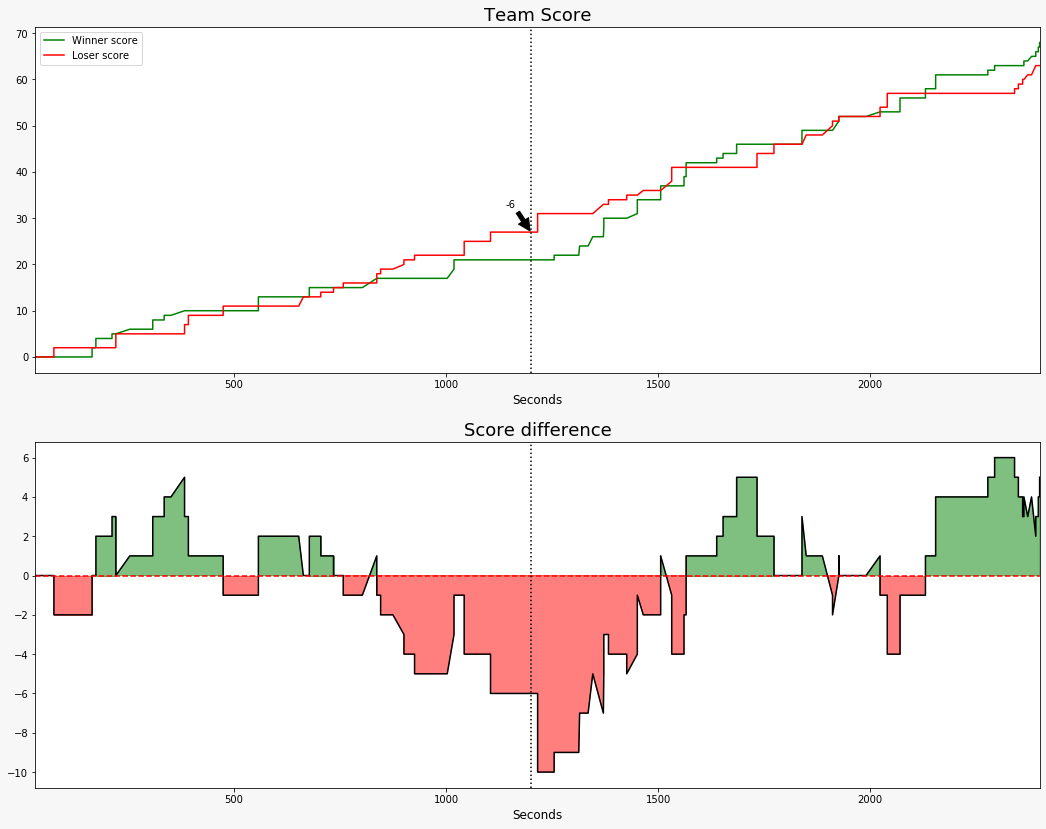

In [41]:
get_game(all_events_m)

Season: 2019
Day number: 11
Final Score: 73 - 54
Haltime score difference: 23.0
Crunchtime score difference: 17.0
Lead Changes: 1.0
Lead Changes in second half: 0.0
Lead Changes in final 3 minutes: 0.0
The game was not competitive


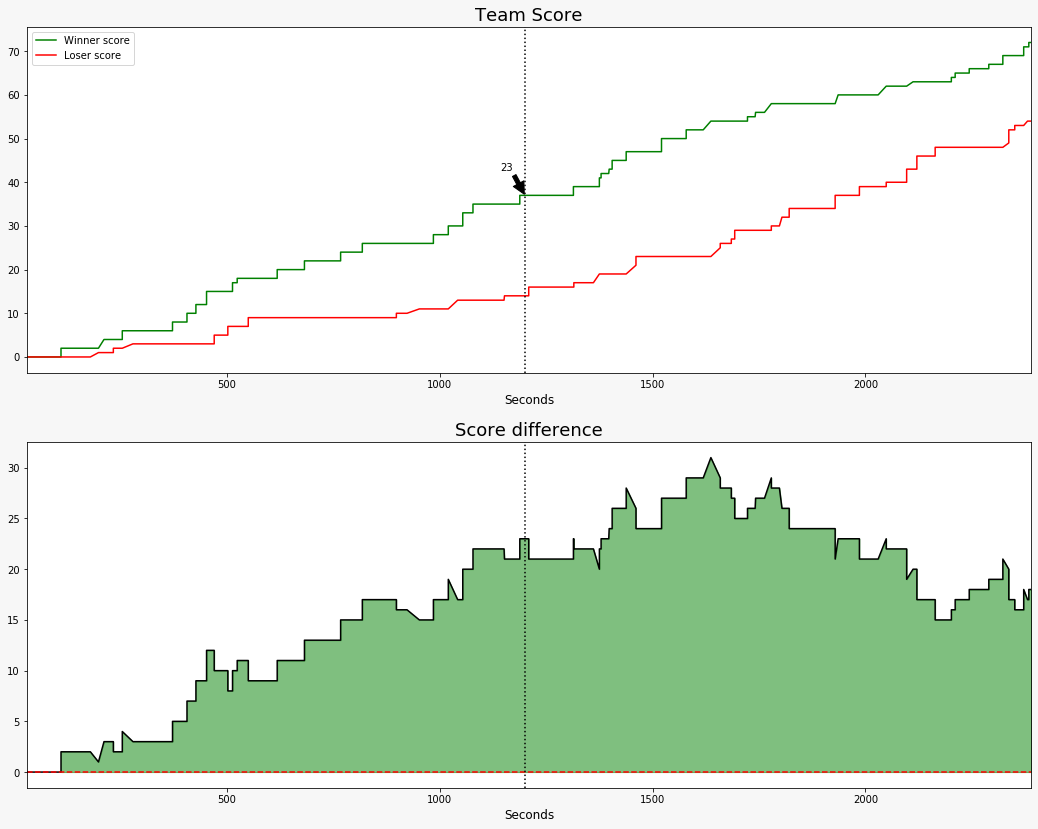

In [42]:
get_game(all_events_w)

Season: 2018
Day number: 121
Final Score: 68 - 64
Haltime score difference: 7.0
Crunchtime score difference: 2.0
Lead Changes: 1
Lead Changes in second half: 0
Lead Changes in final 3 minutes: 0.0
The game was competitive


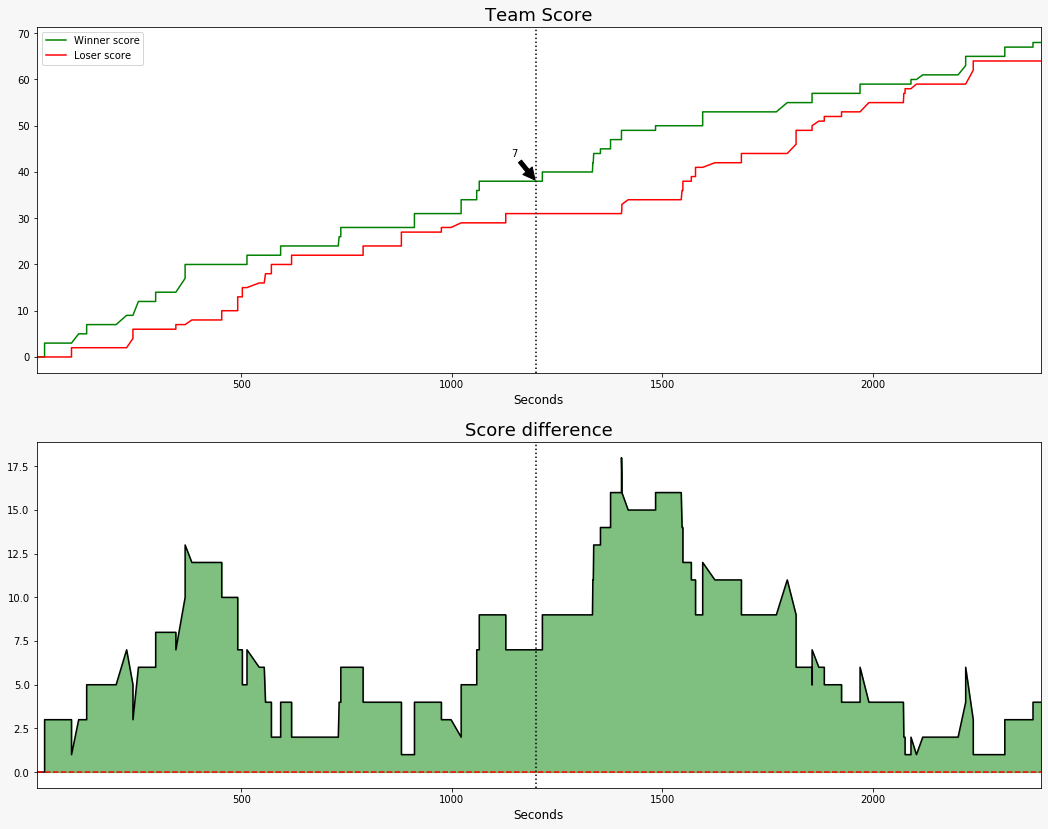

In [43]:
get_game(all_events_m, use_competitive=True, competitive=True)

Season: 2018
Day number: 94
Final Score: 83 - 79
Haltime score difference: 3.0
Crunchtime score difference: -1.0
Lead Changes: 25.0
Lead Changes in second half: 10.0
Lead Changes in final 3 minutes: 3.0
The game was competitive


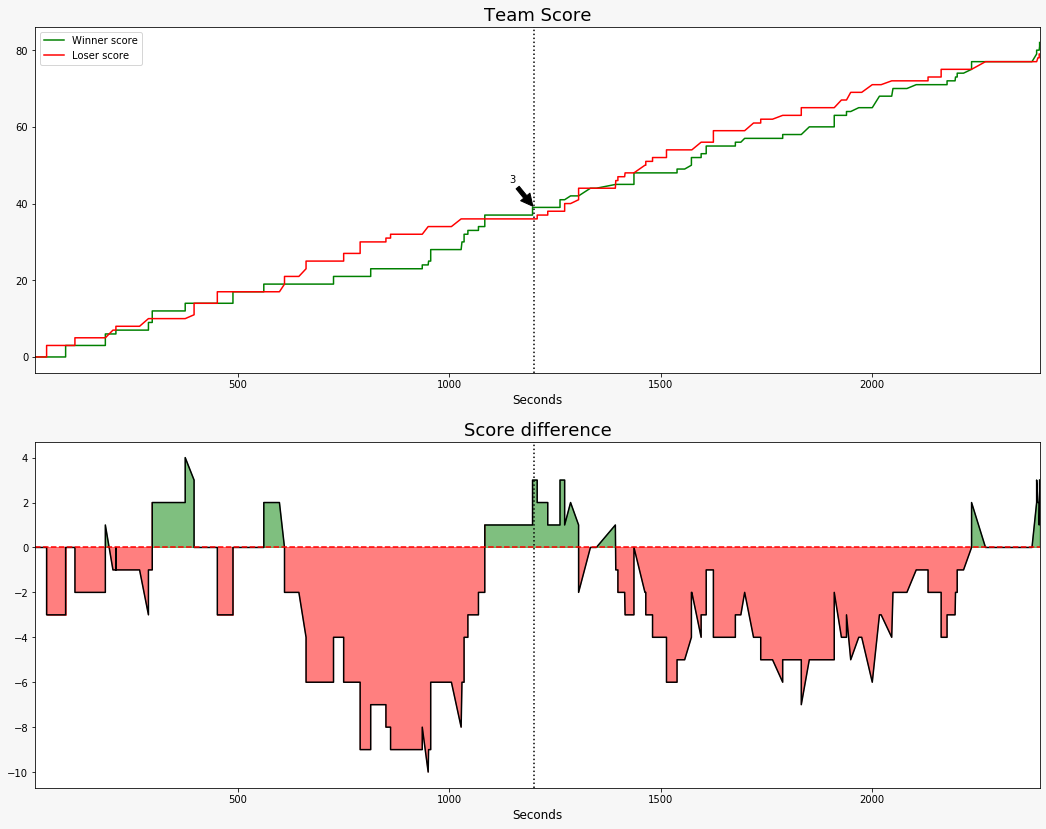

In [44]:
get_game(all_events_w, use_competitive=True, competitive=True)

Season: 2016
Day number: 103
Final Score: 90 - 66
Haltime score difference: 5.0
Crunchtime score difference: 20.0
Lead Changes: 11
Lead Changes in second half: 0
Lead Changes in final 3 minutes: 0.0
The game was not competitive


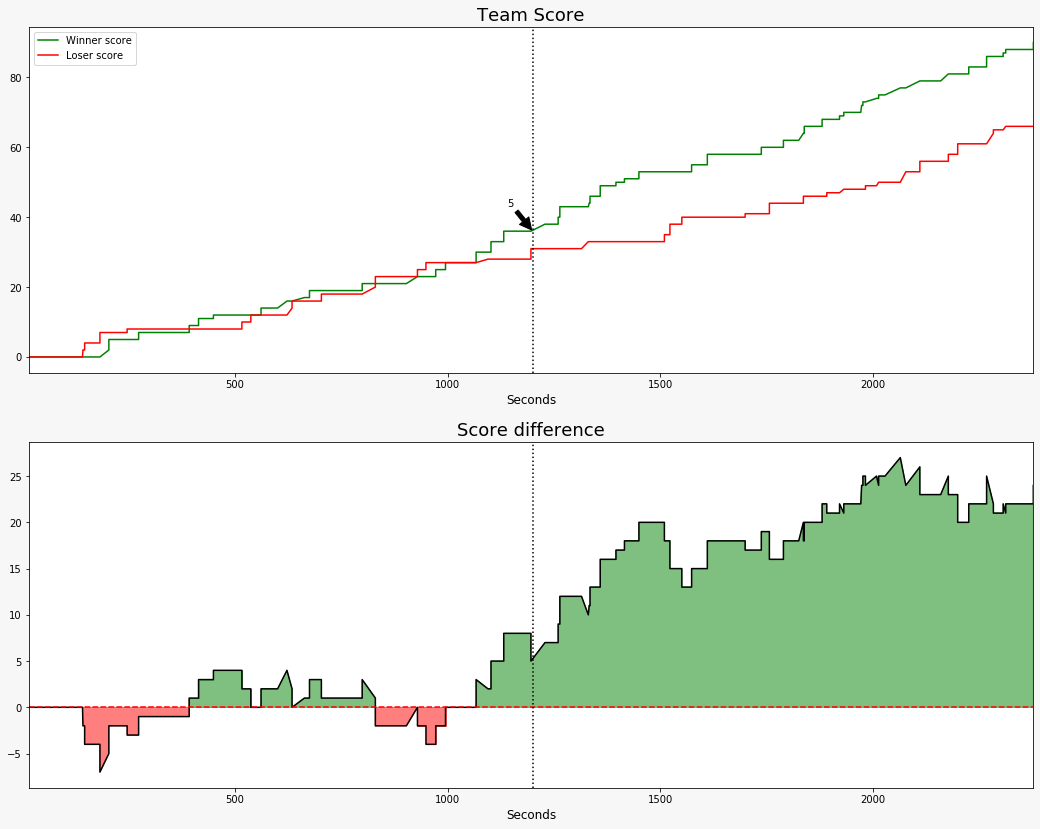

In [45]:
get_game(all_events_m, use_competitive=True, competitive=False)

Season: 2018
Day number: 17
Final Score: 63 - 53
Haltime score difference: 7.0
Crunchtime score difference: 12.0
Lead Changes: 5.0
Lead Changes in second half: 0.0
Lead Changes in final 3 minutes: 0.0
The game was not competitive


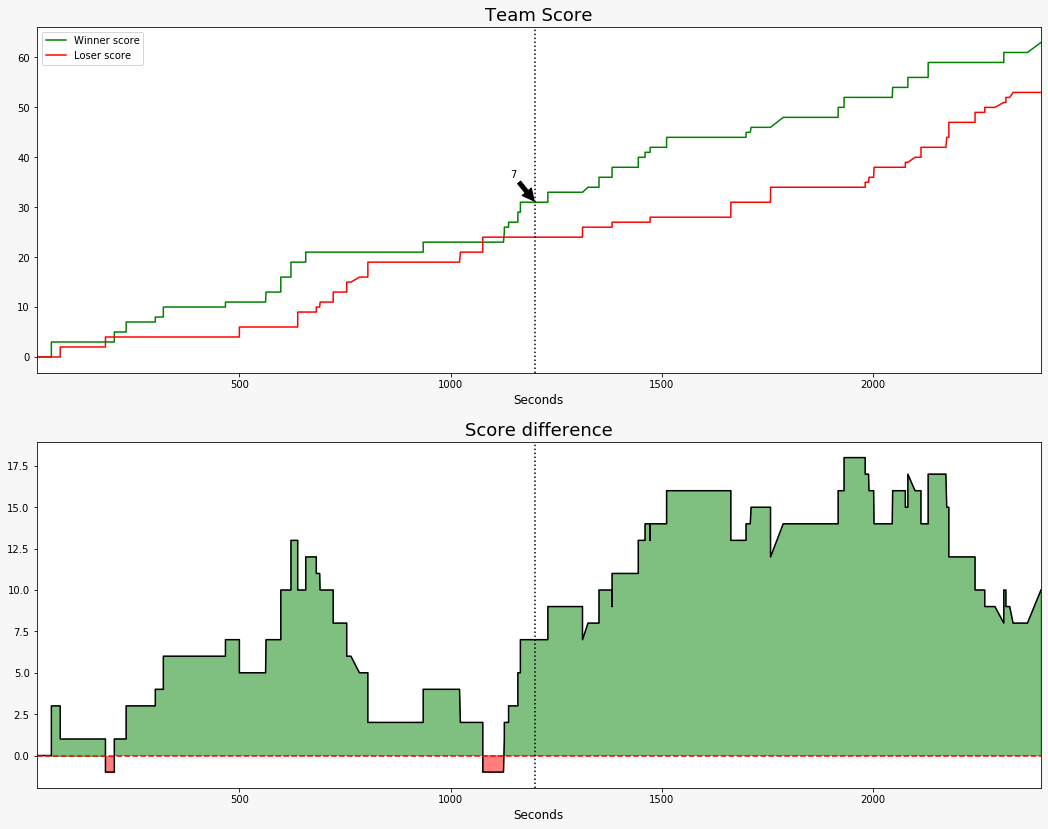

In [46]:
get_game(all_events_w, use_competitive=True, competitive=False)

Season: 2015
Day number: 11
Final Score: 100 - 99
Haltime score difference: 0.0
Crunchtime score difference: -1.0
Lead Changes: 71
Lead Changes in second half: 28
Lead Changes in final 3 minutes: 1.0
The game was competitive


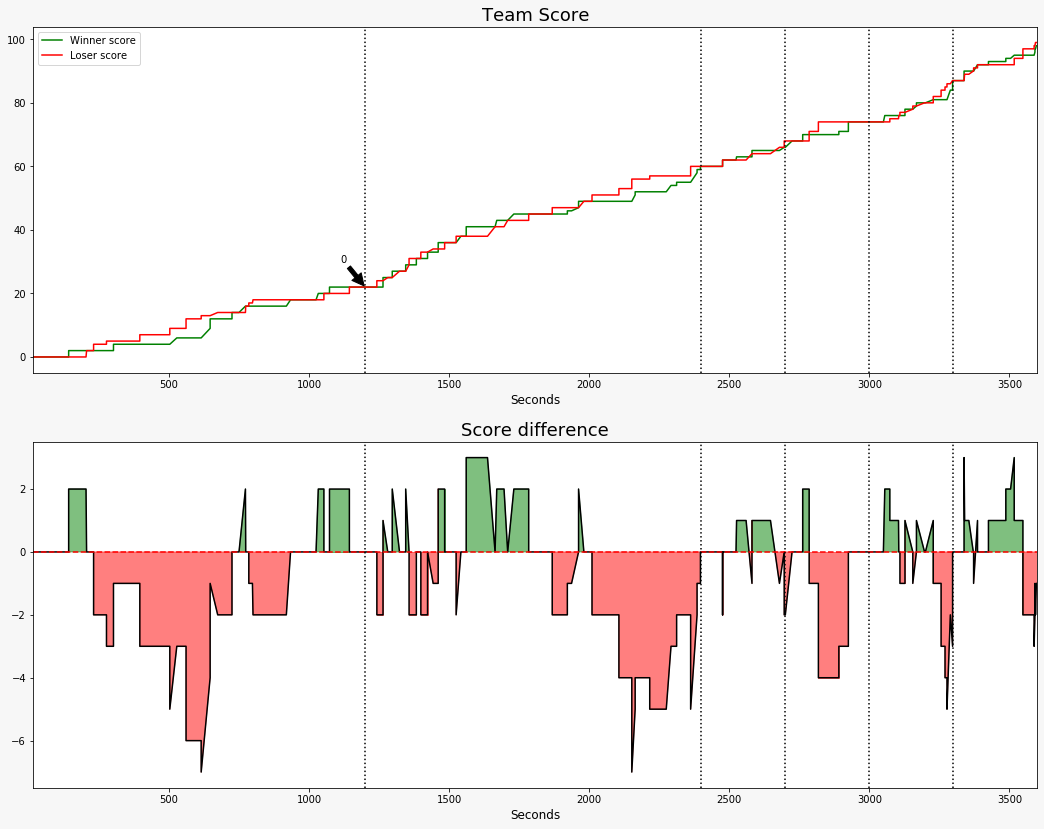

In [47]:
get_game(all_events_m, game_lc=True)

Season: 2016
Day number: 108
Final Score: 100 - 97
Haltime score difference: -1.0
Crunchtime score difference: 3.0
Lead Changes: 56.0
Lead Changes in second half: 7.0
Lead Changes in final 3 minutes: 2.0
The game was competitive


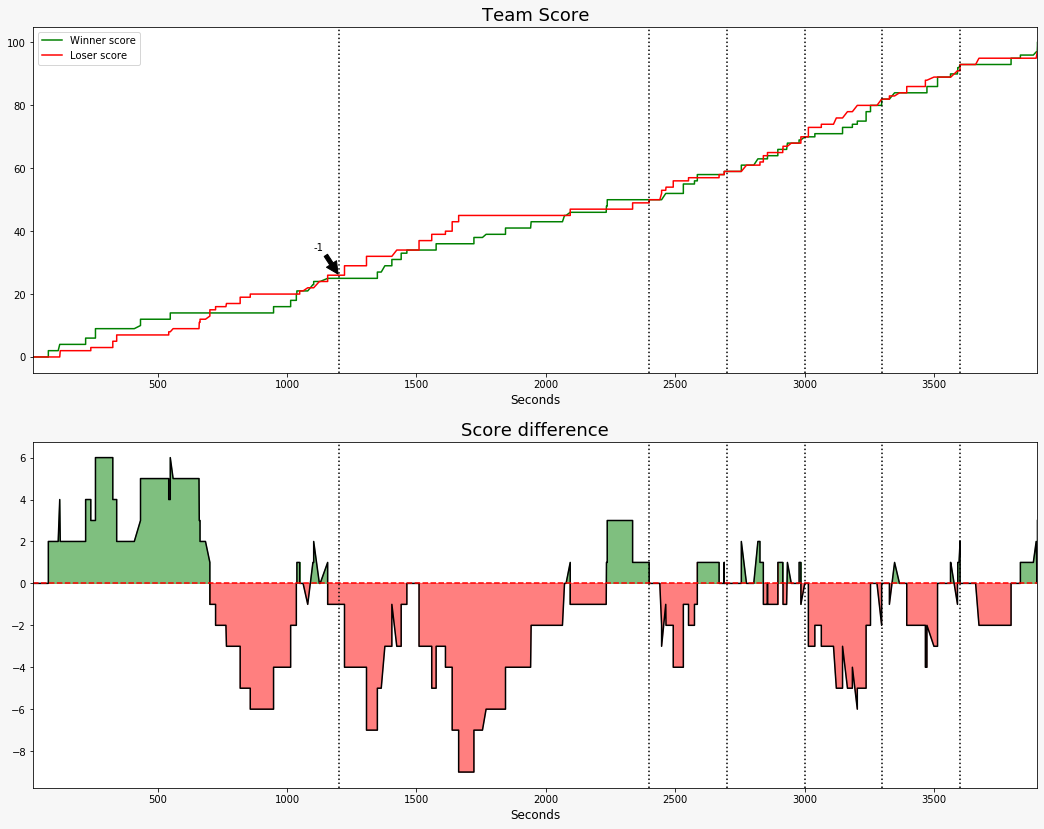

In [48]:
get_game(all_events_w, game_lc=True)

Season: 2016
Day number: 46
Final Score: 96 - 93
Haltime score difference: -3.0
Crunchtime score difference: 2.0
Lead Changes: 61
Lead Changes in second half: 33
Lead Changes in final 3 minutes: 5.0
The game was competitive


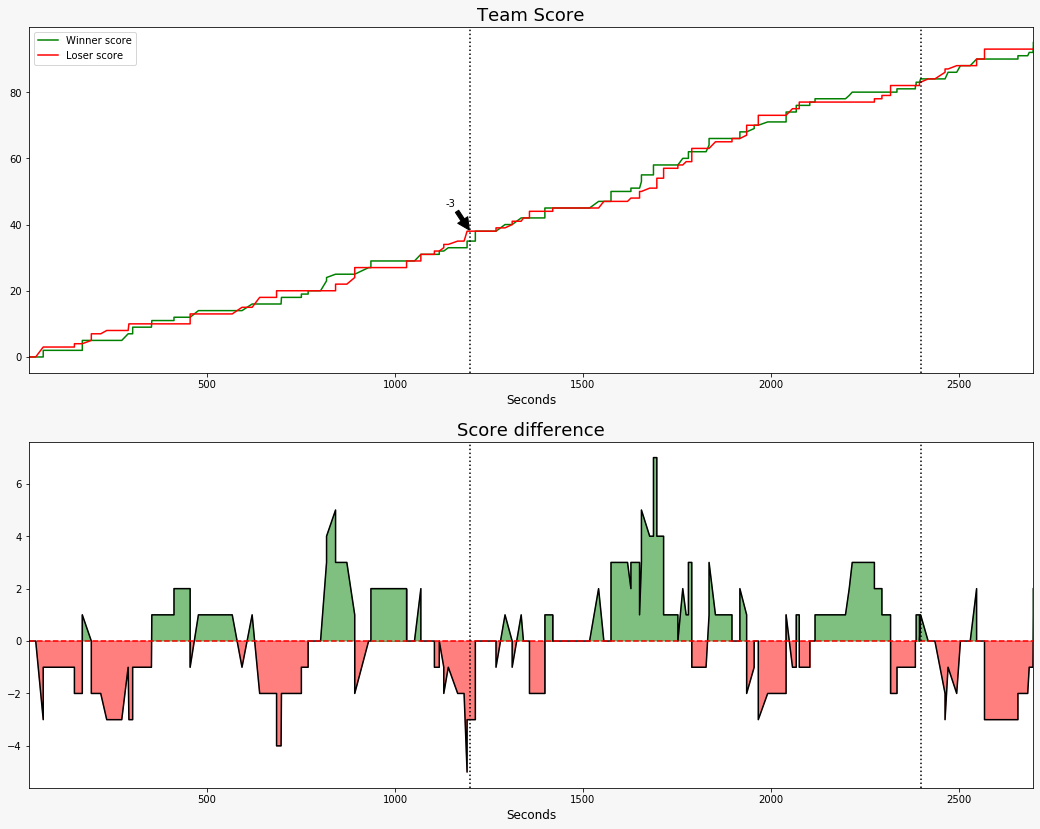

In [49]:
get_game(all_events_m, half_lc=True)

Season: 2018
Day number: 117
Final Score: 79 - 77
Haltime score difference: 5.0
Crunchtime score difference: -3.0
Lead Changes: 49.0
Lead Changes in second half: 36.0
Lead Changes in final 3 minutes: 6.0
The game was competitive


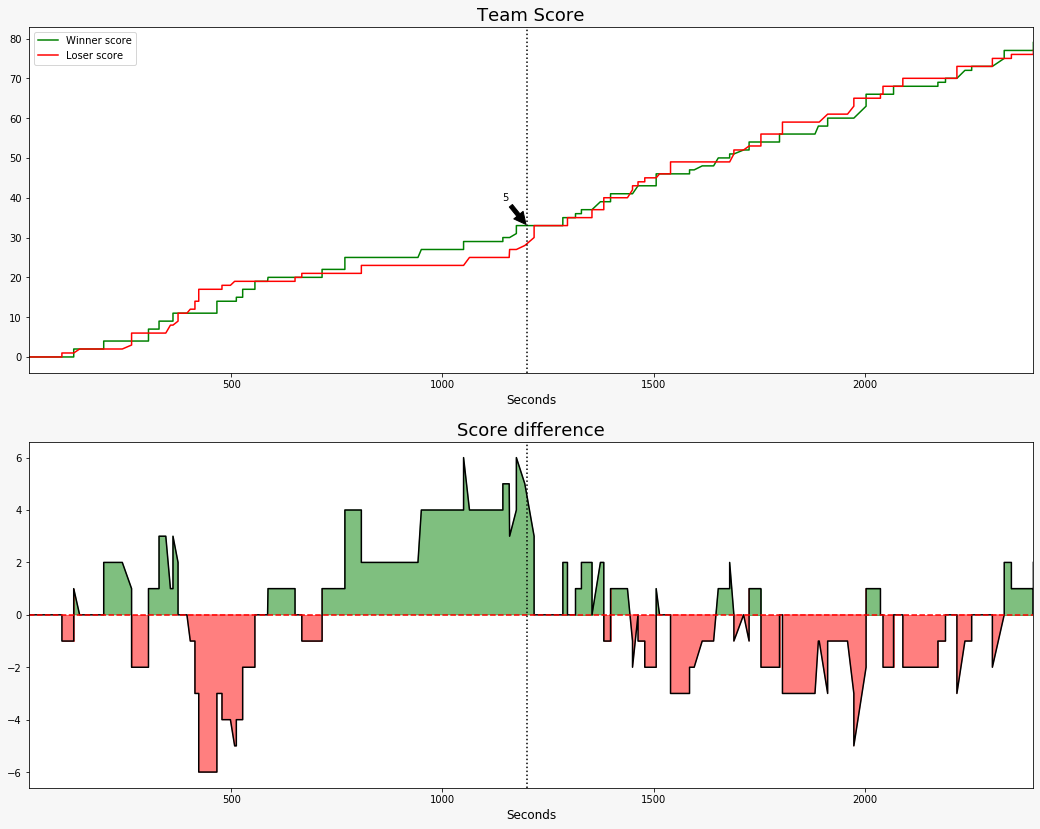

In [50]:
get_game(all_events_w, half_lc=True)

Season: 2016
Day number: 89
Final Score: 92 - 91
Haltime score difference: 1.0
Crunchtime score difference: 0.0
Lead Changes: 34
Lead Changes in second half: 23
Lead Changes in final 3 minutes: 13.0
The game was competitive


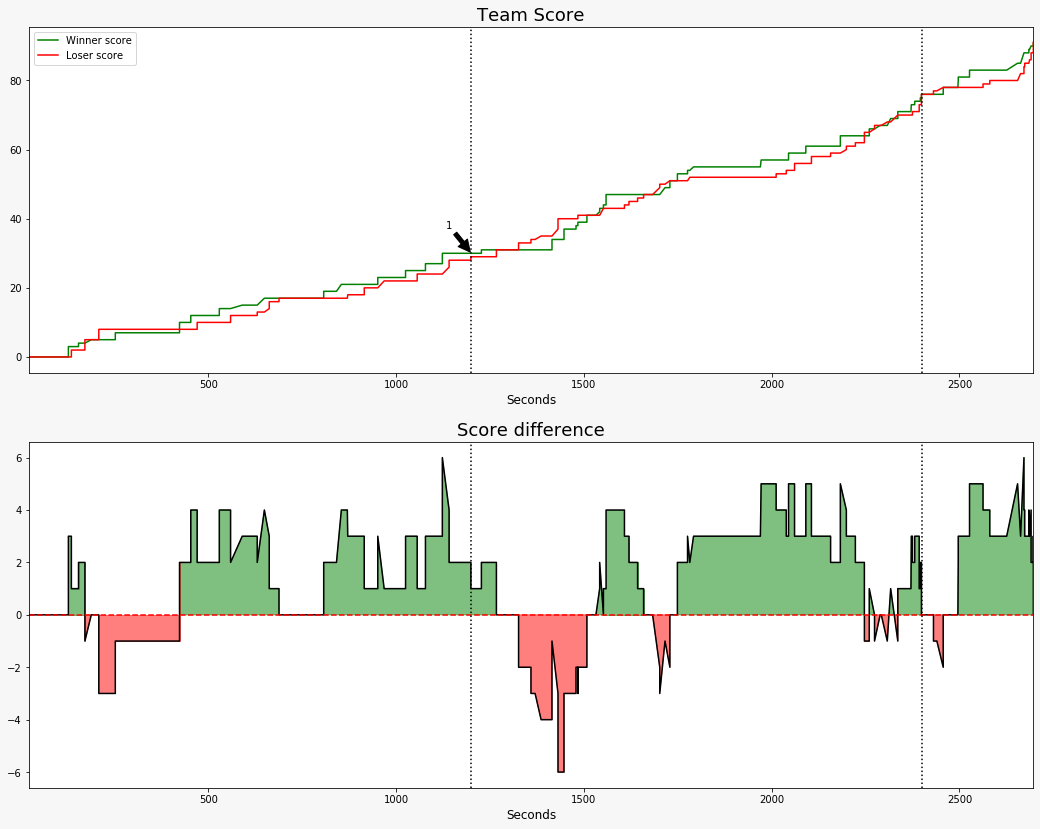

In [51]:
get_game(all_events_m, crunch_lc=True)

Season: 2015
Day number: 56
Final Score: 59 - 57
Haltime score difference: -1.0
Crunchtime score difference: -2.0
Lead Changes: 35.0
Lead Changes in second half: 16.0
Lead Changes in final 3 minutes: 14.0
The game was competitive


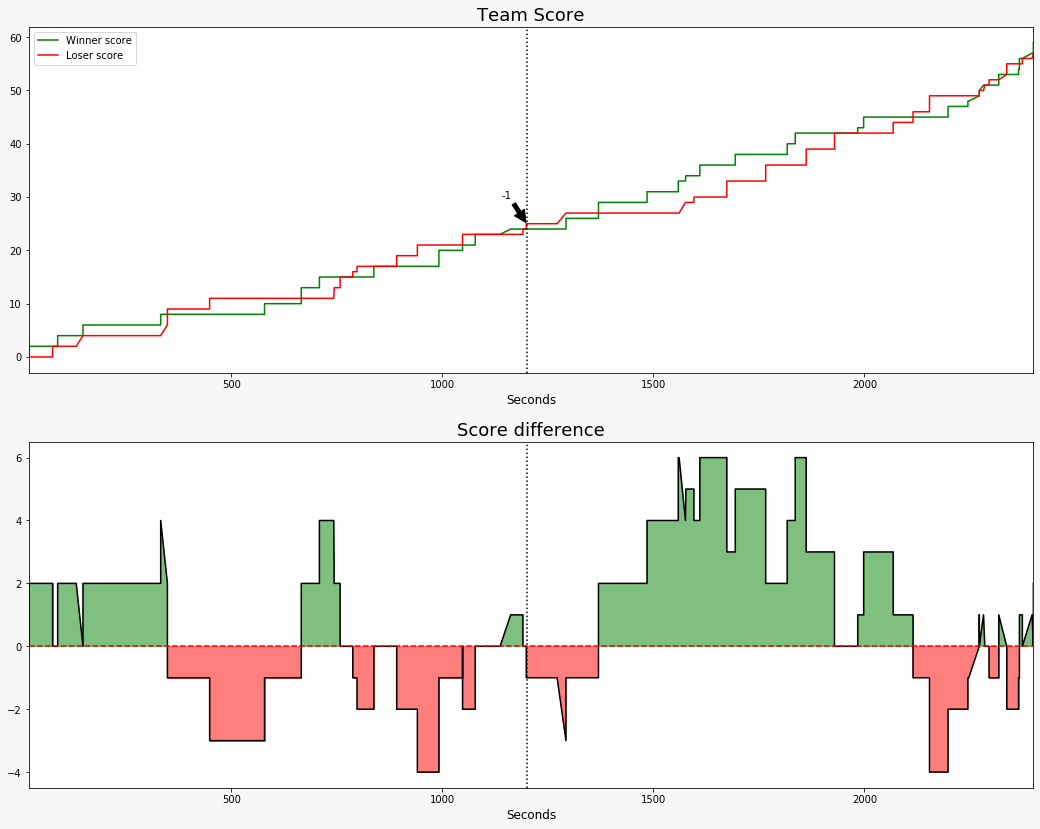

In [52]:
get_game(all_events_w, crunch_lc=True)

Season: 2016
Day number: 99
Final Score: 75 - 74
Haltime score difference: -4.0
Crunchtime score difference: 15.0
Lead Changes: 12
Lead Changes in second half: 3
Lead Changes in final 3 minutes: 2.0
The game was competitive


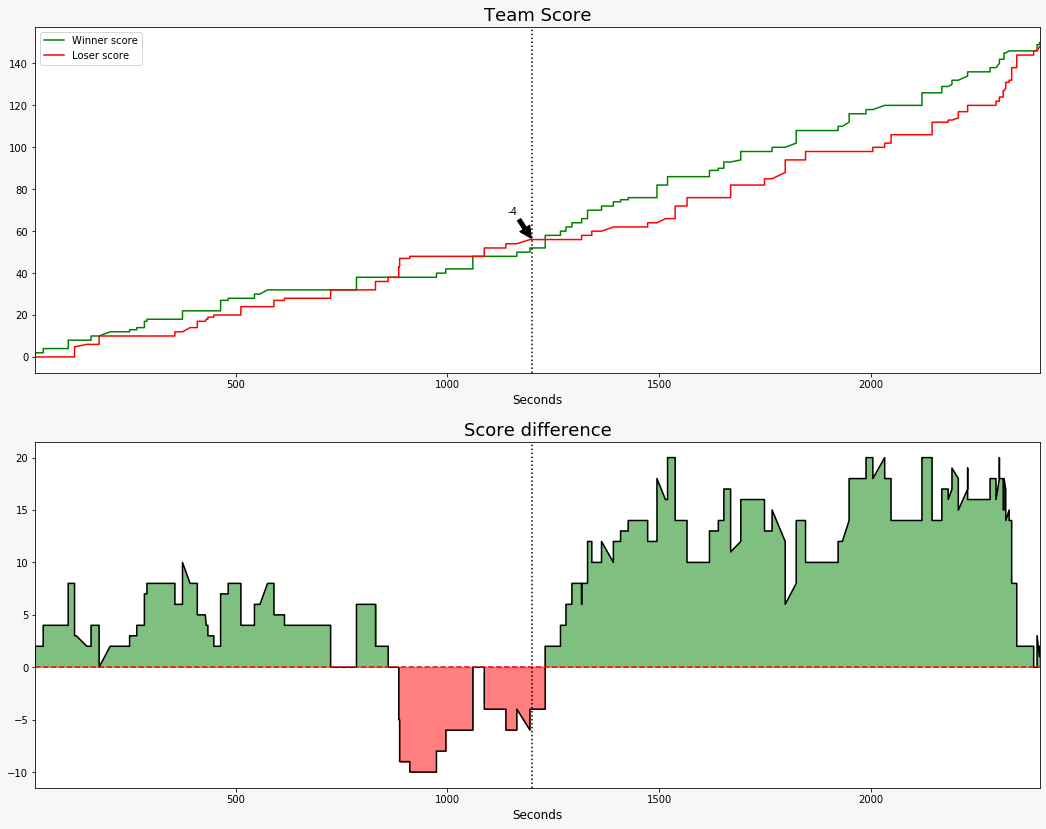

In [53]:
get_game(all_events_m, crunch_score=15, crunch_smaller=False, crunch_lc=True)

Season: 2016
Day number: 96
Final Score: 88 - 75
Haltime score difference: 1.0
Crunchtime score difference: 15.0
Lead Changes: 16.0
Lead Changes in second half: 5.0
Lead Changes in final 3 minutes: 4.0
The game was competitive


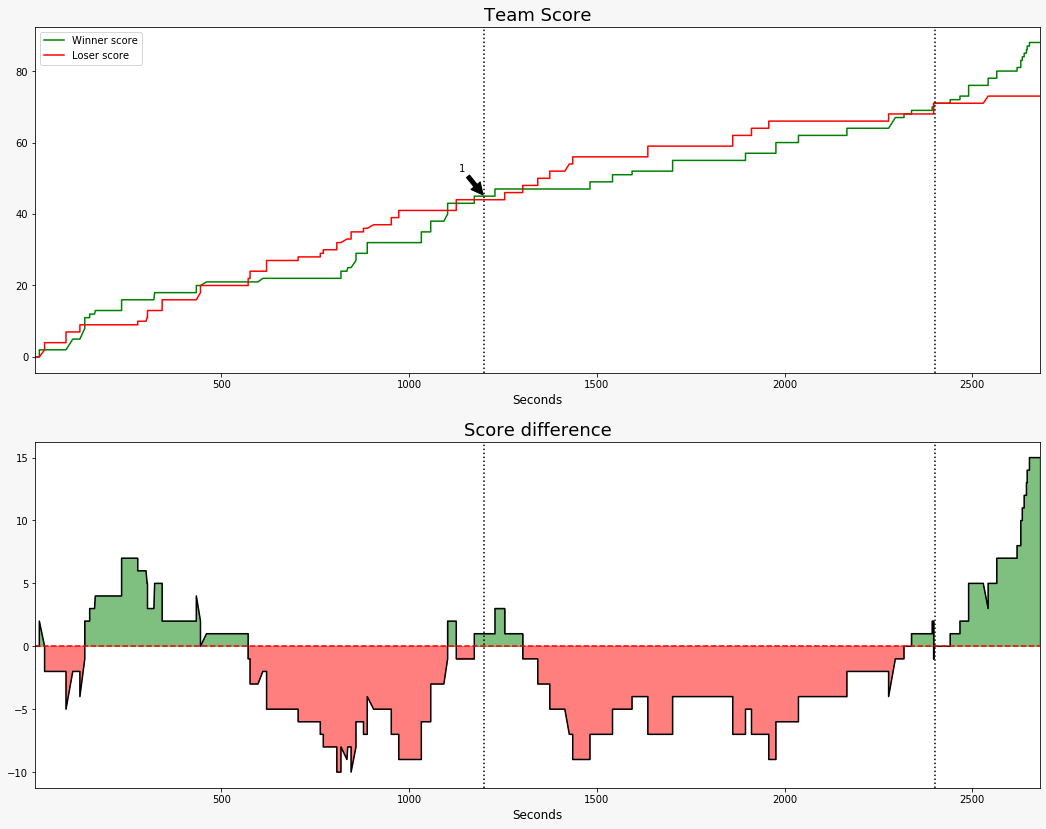

In [54]:
get_game(all_events_w, crunch_score=15, crunch_smaller=False, crunch_lc=True)